In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [17]:
df_feat = joblib.load('df_feat_med.pkl')
sign_cols = [it for it in df_feat.columns if re.search('_stat_rol_sub', it) or it in ['Fighter', 'Opponent', 'Date', 'Result'] ]
# sign_cols = ['wrest_w_stat_rol_sub', 'wrest_l_stat_rol_sub', 'KO_w_stat_rol_sub',
#        'KO_l_stat_rol_sub', 'dec_w_stat_rol_sub', 'dec_l_stat_rol_sub', 'Fighter', 'Opponent', 'Date', 'Result']
X = df_feat[sign_cols]

In [18]:
X_tr = X[X['Date']<pd.Timestamp('2021-09-01')].drop(['Fighter', 'Opponent', 'Date', 'Result'], axis=1)
X_ts = X[X['Date']>=pd.Timestamp('2021-09-01')].drop(['Fighter', 'Opponent', 'Date', 'Result'], axis=1)

# X_tr = X.loc[X['Date']<pd.Timestamp('2021-09-01'), ['wrest_w_stat_rol_sub', 'KO_w_stat_rol_sub', 'dec_w_stat_rol_sub',
#        'ctrl_dam_stat_rol_sub', 'sig_str_stat_rol_sub']]
# X_ts = X.loc[X['Date']>=pd.Timestamp('2021-09-01'), ['wrest_w_stat_rol_sub', 'KO_w_stat_rol_sub', 'dec_w_stat_rol_sub',
#        'ctrl_dam_stat_rol_sub', 'sig_str_stat_rol_sub']]

feat_cols = X_ts.columns
y_tr = X.loc[X['Date']<pd.Timestamp('2021-09-01'), 'Result']
y_ts = X.loc[X['Date']>=pd.Timestamp('2021-09-01'), 'Result']

# Tried to select features

In [23]:
# Select K Best not helped
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=20)
X_tr = selector.fit_transform(X_tr, y_tr)
X_ts = selector.transform(X_ts)

In [35]:
# select lda 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_tr = lda.fit(X_tr, y_tr).transform(X_tr)
X_ts = lda.transform(X_ts)

In [42]:
# not used because of neg values
from sklearn.decomposition import NMF
nmf = NMF(n_components = 5)
X_tr = nmf.fit_transform(X_tr)
X_ts = nmf.transform(X_ts)

ValueError: Negative values in data passed to NMF (input X)

In [19]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_tr, y_tr)
y_p = clf.predict(X_ts)

In [20]:
print(classification_report(y_ts, y_p))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63        48
           1       0.59      0.33      0.43        48

    accuracy                           0.55        96
   macro avg       0.56      0.55      0.53        96
weighted avg       0.56      0.55      0.53        96



In [12]:
def draw_learning_curve(estim,x,y,sizes_l, cv=3):
    train_sizes,train_scores, test_scores = learning_curve(estim, x, y, train_sizes=sizes_l,cv=cv,n_jobs=-1)
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis =1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes,train_mean, color='blue', marker='o', markersize=5, label = 'правильность при обучении')
    plt.fill_between(train_sizes, train_mean+train_std , train_mean - train_std,alpha = 0.2,color='blue')
    plt.plot(train_sizes,test_mean, color='green',marker='s', markersize=5, label='правильность при проверке')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean - test_std, alpha=0.2, color = 'green')
    plt.grid()
    plt.xlabel('количество обучающих образцов')
    plt.ylabel('правильность')
    plt.legend()
    plt.ylim([0.5, 1])
    plt.show()

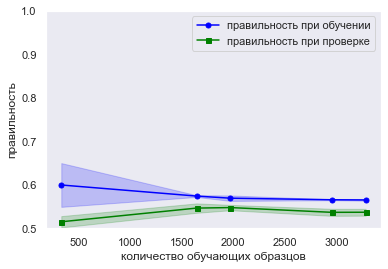

In [13]:
draw_learning_curve(clf, X_tr, y_tr, sizes_l=[0.1, 0.5,0.6,0.9, 1])

In [14]:
print(classification_report(y_tr, clf.predict(X_tr)))

              precision    recall  f1-score   support

           0       0.55      0.76      0.63      2464
           1       0.60      0.37      0.46      2464

    accuracy                           0.56      4928
   macro avg       0.57      0.56      0.55      4928
weighted avg       0.57      0.56      0.55      4928



# Draw Feature importances

C:\tools\Anaconda3\envs\snab\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

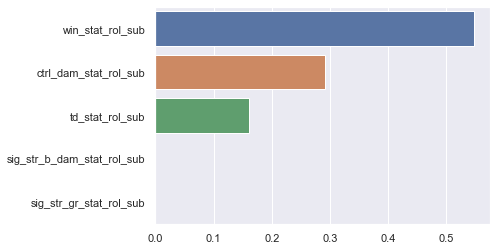

In [21]:
n = 5
idx = np.argsort(clf.feature_importances_)[::-1]
x = feat_cols[idx[:n]]
y = clf.feature_importances_[idx[:n]]

sns.barplot(y,x)

# Hyper Param Opt

In [12]:
import optuna
from optuna.integration import OptunaSearchCV

param_distrs={
            'max_depth':optuna.distributions.IntUniformDistribution(1, 16, step=5),
            'min_samples_split': optuna.distributions.IntUniformDistribution(3, 9, step=1)
            }
opt = OptunaSearchCV(clf, param_distrs, scoring='roc_auc')
opt.fit(X_tr, y_tr)

C:\tools\Anaconda3\envs\snab\lib\site-packages\ipykernel_launcher.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  
[I 2021-11-05 08:11:53,432] A new study created in memory with name: no-name-167c4a75-c9f6-487d-af56-6c5ad17ce7f4
[I 2021-11-05 08:11:53,493] Trial 0 finished with value: 0.5379623206227577 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 0 with value: 0.5379623206227577.
[I 2021-11-05 08:11:53,558] Trial 1 finished with value: 0.5233868487558148 and parameters: {'max_depth': 11, 'min_samples_split': 8}. Best is trial 0 with value: 0.5379623206227577.
[I 2021-11-05 08:11:53,641] Trial 2 finished with value: 0.5186064951538596 and parameters: {'max_depth': 11, 'min_samples_split': 6}. Best is trial 0 with value: 0.5379623206227577.
[I 2021-11-05 08:11:53,725] Trial 3 finished with value: 0.5194391620720061 and parameters: {'max_depth': 11, 'min_samples_split': 6}. Best is tr

OptunaSearchCV(estimator=DecisionTreeClassifier(),
               param_distributions={'max_depth': IntUniformDistribution(high=16, low=1, step=5),
                                    'min_samples_split': IntUniformDistribution(high=9, low=3, step=1)},
               scoring='roc_auc')

In [13]:
opt.best_estimator_

DecisionTreeClassifier(max_depth=1, min_samples_split=4)

In [14]:
print(classification_report(y_tr, opt.best_estimator_.predict(X_tr)))

              precision    recall  f1-score   support

           0       0.54      0.66      0.60      2464
           1       0.57      0.44      0.50      2464

    accuracy                           0.55      4928
   macro avg       0.55      0.55      0.55      4928
weighted avg       0.55      0.55      0.55      4928



In [15]:
print(classification_report(y_ts, opt.best_estimator_.predict(X_ts)))

              precision    recall  f1-score   support

           0       0.55      0.73      0.62        48
           1       0.59      0.40      0.48        48

    accuracy                           0.56        96
   macro avg       0.57      0.56      0.55        96
weighted avg       0.57      0.56      0.55        96

